### Partial Dependence

What partial dependence is?
In short it shows you how 'important' not the feature itself is, but how particular category affects the dependent variable.
For ex. we can determine at what players' age fees are the biggest.
It looks like we can get this info directly from data (without any model). We just make a plot Age vs Fee. But it won't be the 'clean experiment'. What we really want is to calculate category importance all other things being equal.
How can we do that?
If we have a model, we can make an experiment. Let's take all our data and set the age column to 19. Now we have a bunch of data of what will be the fees for every player, every Year and etc for this particular Age. And we can take median across all of the dataset. That will be the thing we want -- median Fee on the player 19th of Age, everything other is beeing equal, so how fees will change across all players if their data will be the same except their age is now 19. That will be the 'pure' value of the age 19 alone (cause other data is not changed). And then we repeat it for every age (from 20 to 36). Comparing these medians we can determine what age influence Fees the most (and how).

### Prepare

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
from plotnine import *

In [5]:
from fastai.tabular import *

In [6]:
from fastai import tabular

In [7]:
from exp.nb_ import *

In [8]:
path=Path('../data/football/')

In [9]:
train_df = pd.read_pickle(path/'trans_over_1000_final.pkl')

In [10]:
cat_vars_tpl = ('season','trs_year','trs_month','trs_day','trs_till_deadline',
            'contract_left_months', 'contract_left_years','age',
            'is_midseason','is_loan','is_end_of_loan',
            'nat_national_name','plr_position_main',
            'plr_other_positions','plr_nationality_name',
            'plr_other_nationality_name','plr_place_of_birth_country_name',
            'plr_foot','plr_height','plr_player_agent','from_club_name','from_club_is_first_team',
            'from_clb_place','from_clb_qualified_to','from_clb_is_champion','from_clb_is_cup_winner',
            'from_clb_is_promoted','from_clb_lg_name','from_clb_lg_country','from_clb_lg_group',
            'from_coach_name', 'from_sport_dir_name',
            'to_club_name','to_club_is_first_team','to_clb_place','to_clb_qualified_to',
            'to_clb_is_champion','to_clb_is_cup_winner','to_clb_is_promoted','to_clb_lg_name','to_clb_lg_country',
            'to_clb_lg_group','to_coach_name', 'to_sport_dir_name',
            'plr_position_0','plr_position_1','plr_position_2',
            'stats_leag_name_0','stats_leag_grp_0','stats_leag_name_1','stats_leag_grp_1','stats_leag_name_2',
            'stats_leag_grp_2')
cont_vars_tpl = ('nat_months_from_debut','nat_matches_played','nat_goals_scored','from_clb_pts_avg',
             'from_clb_goals_diff_avg','to_clb_pts_avg','to_clb_goals_diff_avg','plr_apps_0',
             'plr_apps_1','plr_apps_2','stats_made_goals_0','stats_conc_gols_0','stats_cards_0',
             'stats_minutes_0','stats_team_points_0','stats_made_goals_1','stats_conc_gols_1',
             'stats_cards_1','stats_minutes_1','stats_team_points_1','stats_made_goals_2',
             'stats_conc_gols_2','stats_cards_2','stats_minutes_2','stats_team_points_2', 'pop_log1p')

In [11]:
cat_vars = list(cat_vars_tpl)
cont_vars = list(cont_vars_tpl)
all_vars = cat_vars + cont_vars

In [12]:
dep_var = 'fee'

In [13]:
df = train_df[all_vars + [dep_var]].copy()

In [14]:
np.random.seed(1001)
ln = len(df)
valid_idx = np.random.choice(ln, int(ln*0.2), replace=False)

In [15]:
procs=[FillMissing, Categorify, Normalize]

In [16]:
min_log_y = np.log(500)
max_log_y = np.log(np.max(df[dep_var])*1.2)
y_range = torch.tensor([min_log_y, max_log_y], device=defaults.device)

In [17]:
BS = 128

In [18]:
def emb_sz_rule_reduced(n_cat:int)->int: return min(10, round(1.6 * n_cat**0.56))

In [19]:
#monkey patch embedding rule as 600 floats is too much for our case
tabular.data.emb_sz_rule = emb_sz_rule_reduced

In [20]:
name = 'w_pop_ref-346-median'

In [21]:
p = ld_var(name=f'{name}_hypers', path=path)
p

{'layers': [1000, 500],
 'layers_drop': [0.07, 0.7],
 'emb_drop': 0.7,
 'cycles': 40,
 'w_decay': 0.7,
 'max_lr': 0.001}

In [22]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .databunch(bs=BS))

In [23]:
np.random.seed(1001)
learn = tabular_learner(data, 
                        layers=p['layers'], 
                        ps=p['layers_drop'], 
                        emb_drop=p['emb_drop'], 
                        y_range=y_range, 
                        metrics=exp_mmape,
                        loss_func=MAELossFlat())

In [24]:
learn = learn.load(f'{name}')

### PD

In [27]:
part_dep_multi = partial(get_part_dep_one_list, df=df, learn=learn,
                to_int=True, dep_name='fee')

In [128]:
pd_ = {}

In [25]:
# pd_ = ld_var('pd', path)

In [56]:
pd_['age'] = part_dep_multi(fields=['age'])

In [57]:
age = pd_['age'].query('times > 30')
age

,age,fee,times
10,19.0,1.097299,375.0
7,20.0,1.094542,666.0
15,17.0,1.067255,64.0
12,18.0,1.066428,221.0
3,22.0,1.049063,979.0
1,24.0,1.031698,1071.0
5,21.0,1.018467,825.0
2,25.0,1.011025,1013.0
0,23.0,1.007442,1105.0
4,26.0,0.992558,916.0


In [87]:
pd_['season'] = part_dep_multi(fields=['season'])
pd_['season']

,season,fee,times
24,2019,1.360309,27
19,1999,1.194166,155
1,2018,1.160423,752
20,1998,1.146697,102
15,2001,1.133829,235
0,2017,1.116671,789
17,2000,1.065199,179
2,2016,1.063769,727
22,1996,1.050043,49
4,2007,1.045182,625


In [46]:
def plot_raw(field, df=df):
    return ggplot(df, aes(field, 'fee'))+stat_smooth(se=True, method='loess');
    
def plot_model(field, pd_table):
    '''
    Plots the model.
    It also take into account times, so plot becomes much more resilient, cause not every value treats as equal
    (more occurences means more power)
    '''
    rearr = []
    for var, fee, times in zip(pd_table[field], pd_table['fee'], pd_table['times']):
        for i in range(int(times)):
            rearr.append([var, fee])
    rearr = pd.DataFrame(rearr, columns=[field, 'fee'])
    return ggplot(rearr, aes(field, 'fee'))+stat_smooth(se=True, method='loess');

#### Age

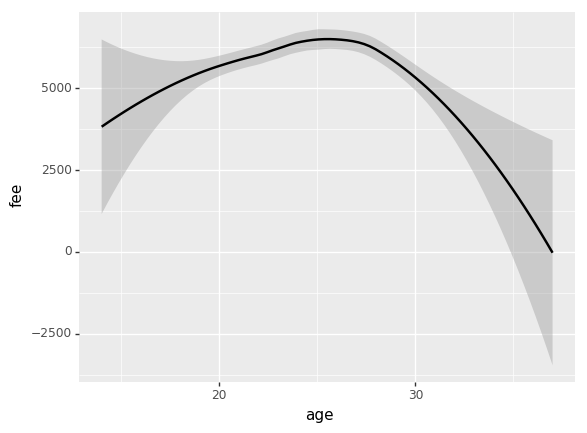

<ggplot: (-9223363301738433371)>

In [52]:
plot_raw(field='age')

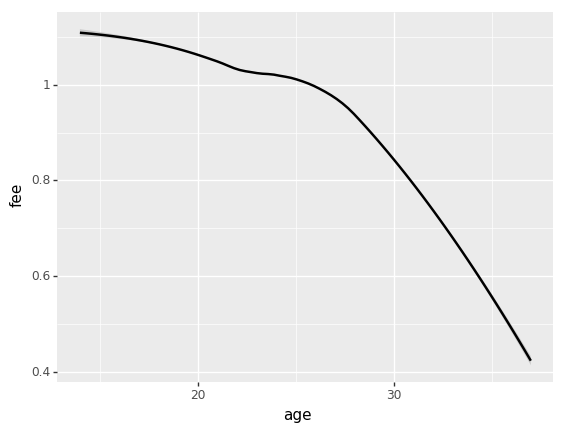

<ggplot: (8735068698025)>

In [90]:
plot_model(field='age', pd_table=pd_['age'])

#### Season

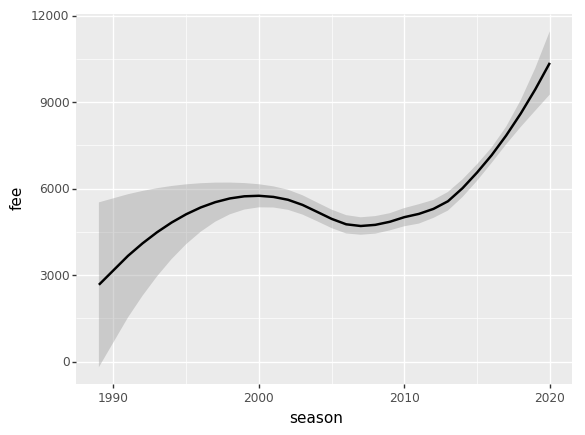

<ggplot: (-9223363301784029380)>

In [85]:
plot_raw(field='season')

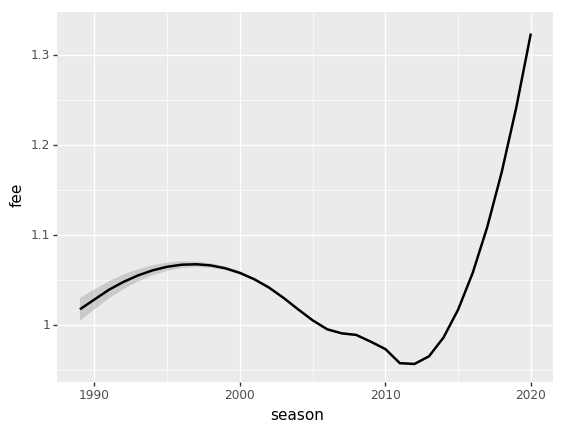

<ggplot: (8735068657654)>

In [91]:
plot_model(field='season', pd_table=pd_['season'])

#### Transfer year

In [107]:
cur_field = 'trs_year'

In [108]:
pd_[cur_field] = part_dep_multi(fields=[cur_field])

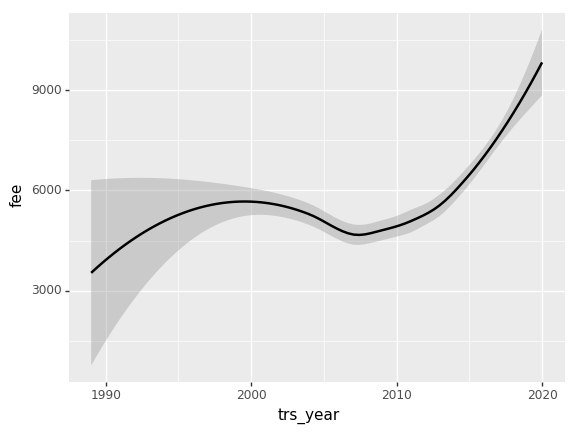

<ggplot: (-9223363301691466450)>

In [109]:
plot_raw(field=cur_field)

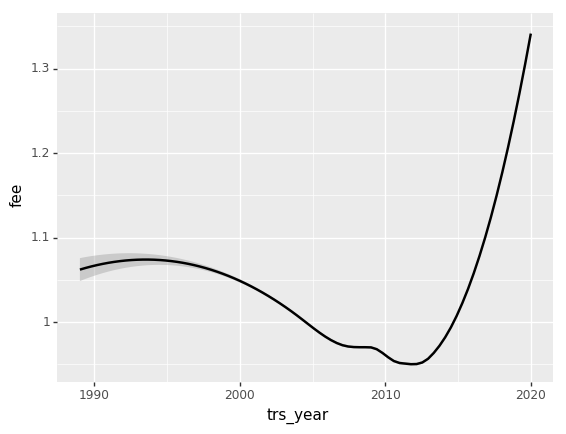

<ggplot: (8735068840547)>

In [110]:
plot_model(field=cur_field, pd_table=pd_[cur_field])

#### Season composite

In [48]:
cur_field = 'comp_season'

In [41]:
comp_season = get_part_dep(df=df, learn=learn, bs=BS, coef=1,
                                  dep_name=dep_var, is_sorted=True, fields=[['season', 'trs_year']])

In [42]:
mask = comp_season.apply(lambda x: x['value'][0] == x['value'][1], axis=1)
comp_season = comp_season[mask].copy()

In [43]:
comp_season['value'] = comp_season['value'].apply(lambda x: int(x[0]))

In [59]:
comp_season.rename({'value':cur_field}, axis=1, inplace=True)
comp_season.drop(columns='feature', inplace=True)
pd_[cur_field] = comp_season

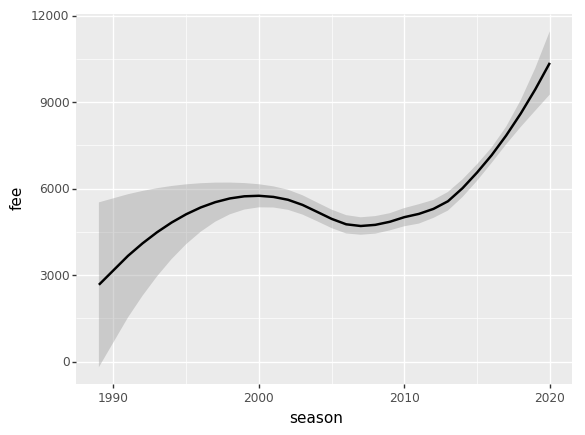

<ggplot: (-9223363290475792040)>

In [47]:
plot_raw(field='season')

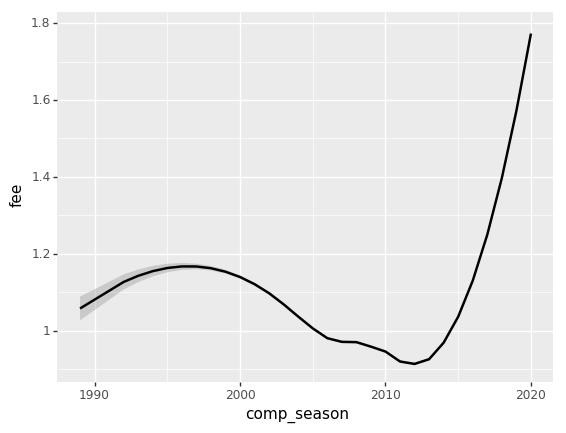

<ggplot: (8746378012150)>

In [69]:
plot_model(field=cur_field, pd_table=pd_[cur_field])

#### Deadline

In [45]:
cur_field = 'trs_till_deadline'

In [46]:
pd_[cur_field] = part_dep_multi(fields=[cur_field])

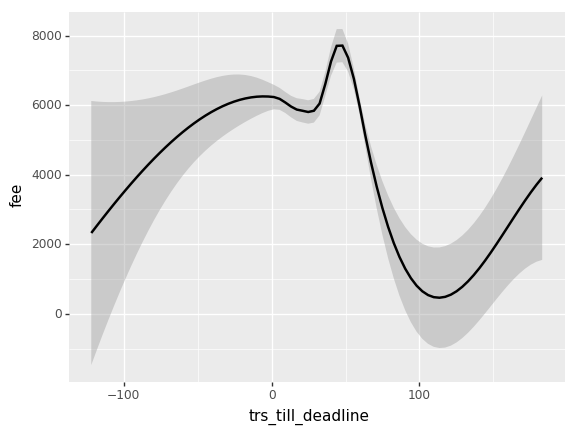

<ggplot: (-9223363301785937120)>

In [97]:
plot_raw(field=cur_field)

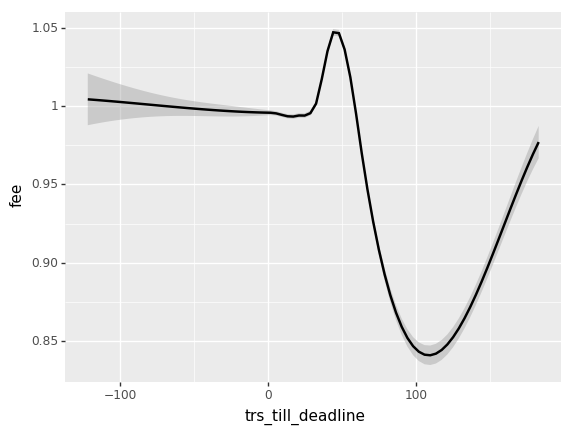

<ggplot: (-9223363301785937969)>

In [98]:
plot_model(field=cur_field, pd_table=pd_[cur_field])

#### From coach

In [138]:
cur_field = 'from_coach_name'

In [127]:
pd_[cur_field] = part_dep_multi(fields=[cur_field], coef=10)

In [128]:
pd_[cur_field].head(20)

,from_coach_name,fee,times
237,Joaquín Caparrós,1.385538,10
247,Roberto De Zerbi,1.300894,10
100,Davide Ballardini,1.300215,18
71,Gregorio Manzano,1.299536,21
238,Julio Velázquez,1.292973,10
9,Diego Simeone,1.283241,52
183,Vanderlei Luxemburgo,1.271472,12
219,Óscar García,1.244314,10
180,Sir Bobby Robson,1.243635,12
17,Leonardo Jardim,1.238429,43


In [139]:
pd_[cur_field].tail(20)

,from_coach_name,fee,times
218,Marco van Basten,0.838746,10
131,Eduardo Berizzo,0.838294,15
149,Jean-Marc Furlan,0.836936,14
196,Kevin Keegan,0.834446,11
191,Erwin Koeman,0.829920,11
136,Manolo Jiménez,0.824262,15
121,Ron Jans,0.824035,15
113,Frank Rijkaard,0.819735,17
137,Vítor Pereira,0.818604,15
98,Paul Le Guen,0.810003,18


#### To coach

In [140]:
cur_field = 'to_coach_name'

In [141]:
pd_[cur_field] = part_dep_multi(fields=[cur_field], coef=10)

In [142]:
pd_[cur_field].head(20)

,to_coach_name,fee,times
263,José Antonio Camacho,1.488878,11
71,Marcello Lippi,1.483129,30
135,Javier Irureta,1.379905,21
272,Dino Zoff,1.374406,10
178,Paul Clement,1.356411,16
54,Fabio Capello,1.344914,36
32,Leonardo Jardim,1.339415,42
249,Jorge Sampaoli,1.328918,11
120,Alberto Malesani,1.319170,22
252,Gareth Southgate,1.311422,11


In [143]:
pd_[cur_field].tail(20)

,to_coach_name,fee,times
271,Frédéric Hantz,0.813047,10
238,Massimo Ficcadenti,0.808048,12
129,Tony Mowbray,0.790802,22
175,Jos Luhukay,0.789803,16
182,Christian Gross,0.787553,16
157,Markus Weinzierl,0.784554,18
265,Ewald Lienen,0.781055,11
204,José Luis Mendilibar,0.764309,14
176,Dave Jones,0.763809,16
158,Guy Lacombe,0.759310,18


#### Contract

In [50]:
cur_field = 'plr_player_agent'

In [51]:
pd_[cur_field] = part_dep_multi(fields=[cur_field], coef=30)

In [52]:
pd_[cur_field].head(30)

,plr_player_agent,fee,times
25,Branchini Associati S.p.A.,1.236803,42
35,James Grant Sports Management,1.197583,31
23,Alessandro Lucci - WSA,1.195363,45
4,Gestifute,1.182782,148
37,PRO Profil GmbH,1.141342,31
3,not clarified,1.136408,206
31,Bahía Internacional,1.128022,33
10,WMG Management (SFX Sports),1.123335,65
38,ISMG International,1.104341,30
27,Gr Sports,1.102368,41


In [57]:
train_df.query("plr_player_agent == 'WMG Management (SFX Sports)'")[['player_name', 'fee', 'trs_year']]

,player_name,fee,trs_year
613,Andy van der Meyde,9000.0,2005.0
614,Andy van der Meyde,12000.0,2003.0
1357,Scott Parker,4500.0,2013.0
1358,Scott Parker,6200.0,2011.0
1359,Scott Parker,9700.0,2007.0
1360,Scott Parker,9000.0,2005.0
1361,Scott Parker,14000.0,2004.0
1450,Robbie Keane,3750.0,2011.0
1451,Robbie Keane,1200.0,2011.0
1452,Robbie Keane,1200.0,2010.0


### PD All

#### PD simple

In [71]:
#Takes me 1,5 hour to run
prt_dep_all = get_part_dep(df=df, learn=learn, bs=BS, coef=0.85, 
             dep_name=dep_var, is_sorted=True)
prt_dep_all

,feature,value,fee,times
0,season,2019,1.359585,27.0
1,season,1999,1.193820,155.0
2,season,2018,1.159221,752.0
3,season,1998,1.145585,102.0
4,season,2001,1.132942,235.0
5,season,2017,1.115476,789.0
6,season,2000,1.064721,179.0
7,season,2016,1.062656,727.0
8,season,1996,1.049718,49.0
9,season,2007,1.046345,625.0


In [72]:
sv_var(var=prt_dep_all, name='prt_dep_all', path=path)

In [26]:
prt_dep_all = ld_var(name='prt_dep_all', path=path)

In [73]:
list(prt_dep_all.feature.unique())

['season',
 'trs_year',
 'trs_month',
 'trs_day',
 'trs_till_deadline',
 'contract_left_months',
 'contract_left_years',
 'age',
 'is_midseason',
 'is_loan',
 'is_end_of_loan',
 'nat_national_name',
 'plr_position_main',
 'plr_other_positions',
 'plr_nationality_name',
 'plr_other_nationality_name',
 'plr_place_of_birth_country_name',
 'plr_foot',
 'plr_height',
 'plr_player_agent',
 'from_club_name',
 'from_club_is_first_team',
 'from_clb_place',
 'from_clb_qualified_to',
 'from_clb_is_champion',
 'from_clb_is_cup_winner',
 'from_clb_is_promoted',
 'from_clb_lg_name',
 'from_clb_lg_country',
 'from_clb_lg_group',
 'from_coach_name',
 'from_sport_dir_name',
 'to_club_name',
 'to_club_is_first_team',
 'to_clb_place',
 'to_clb_qualified_to',
 'to_clb_is_champion',
 'to_clb_is_cup_winner',
 'to_clb_is_promoted',
 'to_clb_lg_name',
 'to_clb_lg_country',
 'to_clb_lg_group',
 'to_coach_name',
 'to_sport_dir_name',
 'plr_position_0',
 'plr_position_1',
 'plr_position_2',
 'stats_leag_name_0',

In [74]:
def show_feat(feature, min_occ=20):
    return prt_dep_all.query(f"(feature == '{feature}') and (times > {min_occ})")

##### position

In [75]:
show_feat('plr_position_main')

,feature,value,fee,times
485,plr_position_main,Attacking Midfield,1.033228,730.0
486,plr_position_main,Left Winger,1.014323,545.0
487,plr_position_main,Right Winger,1.014017,587.0
488,plr_position_main,Centre-Forward,1.014015,2459.0
489,plr_position_main,Central Midfield,1.006746,1041.0
490,plr_position_main,Defensive Midfield,1.005112,835.0
491,plr_position_main,Centre-Back,0.994888,1587.0
492,plr_position_main,Second Striker,0.986625,251.0
493,plr_position_main,Left Midfield,0.978775,159.0
494,plr_position_main,Goalkeeper,0.971062,417.0


##### national team

In [35]:
show_feat('nat_national_name', min_occ=60)

,feature,value,fee,times
296,nat_national_name,England,1.236882,318.0
298,nat_national_name,Brazil,1.227276,477.0
301,nat_national_name,France,1.186890,328.0
306,nat_national_name,Spain,1.147273,258.0
309,nat_national_name,Argentina,1.128014,422.0
312,nat_national_name,Netherlands,1.124623,250.0
313,nat_national_name,Italy,1.116275,484.0
317,nat_national_name,Colombia,1.104306,127.0
320,nat_national_name,Democratic Republic of the Congo,1.087746,62.0
322,nat_national_name,Paraguay,1.070666,63.0


##### From club

In [36]:
cur_field = 'from_club_name'

In [37]:
pd_[cur_field] = part_dep_multi(fields=[cur_field], coef=10)

In [38]:
pd_[cur_field].head(20)

,from_club_name,fee,times
172,Nottm Forest,1.311562,19
126,Shakhtar D.,1.234985,25
30,Atalanta,1.215716,55
31,River Plate,1.214965,55
114,Grêmio,1.193193,27
144,AC Parma,1.189189,22
134,Hull City,1.187187,23
145,Santos FC,1.180931,22
44,Boca Juniors,1.174925,45
59,Fulham,1.167167,40


In [39]:
pd_[cur_field].tail(20)

,from_club_name,fee,times
95,Chievo Verona,0.879379,30
153,CA Osasuna,0.869620,21
37,PSV Eindhoven,0.866617,51
214,UD Almería,0.866366,13
254,NEC Nijmegen,0.861361,10
234,Karlsruher SC,0.860861,12
235,Real Valladolid,0.860110,12
197,VfL Bochum,0.859860,16
222,Marítimo,0.859610,13
210,Genclerbirligi,0.859359,14


##### To club

In [40]:
cur_field = 'to_club_name'

In [41]:
pd_[cur_field] = part_dep_multi(fields=[cur_field], coef=10)

In [42]:
pd_[cur_field].head(20)

,to_club_name,fee,times
128,Anzhi,1.536122,26
34,Man Utd,1.454101,79
4,Chelsea,1.332700,112
110,Milan,1.308528,32
121,RB Leipzig,1.299565,28
139,Bournemouth,1.298479,22
3,Liverpool,1.279196,115
133,AC Parma,1.278110,24
111,Dynamo Kyiv,1.256654,32
124,Shakhtar D.,1.255024,27


In [43]:
pd_[cur_field].tail(20)

,to_club_name,fee,times
108,Reading,0.801195,33
91,Espanyol,0.799837,40
131,FC Sochaux,0.797121,24
89,Hannover 96,0.796850,41
98,AZ Alkmaar,0.789245,37
166,Bristol City,0.787887,13
132,Boca Juniors,0.785714,24
163,CA Osasuna,0.782998,14
76,Club Brugge,0.779468,49
129,FC Nantes,0.777838,25


##### Foot

In [44]:
cur_field = 'plr_foot'

In [45]:
pd_[cur_field] = part_dep_multi(fields=[cur_field], coef=10)

In [46]:
pd_[cur_field]

,plr_foot,fee,times
2,both,1.014151,658
0,right,1.000000,6643
1,left,0.990011,2153


##### National matches

In [39]:
cur_field = 'nat_matches_played'

In [62]:
pd_[cur_field] = part_dep_multi(fields=[cur_field], coef=10)

In [50]:
pd_[cur_field].head(10)

,nat_matches_played,fee,times
94,106.0,1.077251,18.0
106,107.0,1.076749,11.0
95,112.0,1.076499,17.0
89,110.0,1.076499,21.0
81,105.0,1.076248,24.0
86,116.0,1.075746,22.0
108,102.0,1.074994,10.0
98,101.0,1.073990,14.0
99,100.0,1.073489,14.0
105,99.0,1.072987,12.0


In [52]:
pd_[cur_field].tail(20)

,nat_matches_played,fee,times
31,20.0,0.872335,61.0
17,19.0,0.868322,93.0
13,18.0,0.864309,114.0
18,17.0,0.859544,91.0
19,16.0,0.855029,88.0
12,15.0,0.849511,120.0
15,14.0,0.845749,106.0
14,13.0,0.841736,109.0
10,12.0,0.837221,126.0
16,11.0,0.832957,106.0


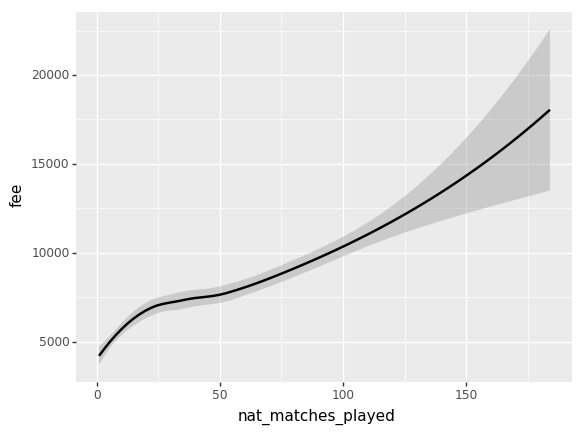

<ggplot: (-9223363269081368071)>

In [55]:
plot_raw(field=cur_field)

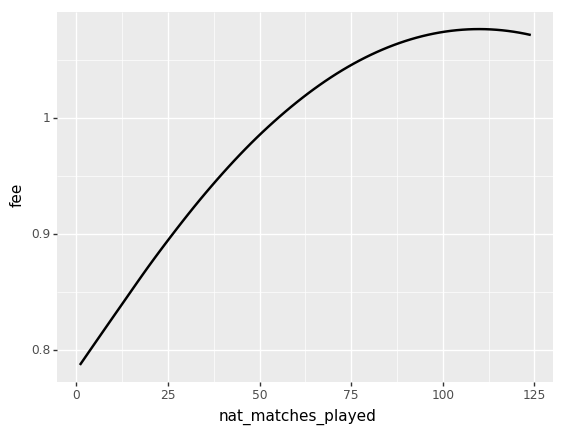

<ggplot: (8767773383467)>

In [56]:
plot_model(field=cur_field, pd_table=pd_[cur_field])

#### PD less interconnection

In [23]:
fields = [
    ['season', 'trs_year'],
     'trs_month',
     'trs_day',
     'trs_till_deadline',
     ['contract_left_months', 'contract_left_years'],
     'age',
     'is_midseason',
     'is_loan',
     'is_end_of_loan',
     'nat_national_name', 
     ['plr_position_main', 'plr_position_0'],
     'plr_other_positions',
     ['plr_nationality_name', 'plr_place_of_birth_country_name'],
     'plr_other_nationality_name',
     'plr_foot',
     'plr_height',
     'plr_player_agent',
     ['from_club_name', 'from_club_is_first_team', 'from_clb_lg_name', 'from_clb_lg_country', 'from_clb_lg_group'],
     ['from_clb_place', 'from_clb_qualified_to', 'from_clb_is_champion', 'from_clb_is_cup_winner', 'from_clb_is_promoted'] ,
     'from_coach_name',
     'from_sport_dir_name',
     ['to_club_name', 'to_club_is_first_team', 'to_clb_lg_name',  'to_clb_lg_country', 'to_clb_lg_group'],
     ['to_clb_place', 'to_clb_qualified_to', 'to_clb_is_champion', 'to_clb_is_cup_winner', 'to_clb_is_promoted'] ,
     'to_coach_name',
     'to_sport_dir_name',
     'plr_position_1',
     'plr_position_2',
     ['stats_leag_name_0', 'stats_leag_grp_0'],
     ['stats_leag_name_1', 'stats_leag_grp_1'],
     ['stats_leag_name_2', 'stats_leag_grp_2'],
     'nat_months_from_debut',
     'nat_matches_played',
     'nat_goals_scored',
     'from_clb_pts_avg',
     'from_clb_goals_diff_avg',
     'to_clb_pts_avg',
     'to_clb_goals_diff_avg',
     'plr_apps_0',
     'plr_apps_1',
     'plr_apps_2',
     'stats_made_goals_0',
     'stats_conc_gols_0',
     'stats_cards_0',
     'stats_minutes_0',
     'stats_team_points_0',
     'stats_made_goals_1',
     'stats_conc_gols_1',
     'stats_cards_1',
     'stats_minutes_1',
     'stats_team_points_1',
     'stats_made_goals_2',
     'stats_conc_gols_2',
     'stats_cards_2',
     'stats_minutes_2',
     'stats_team_points_2',
     'pop_log1p'
    ]

In [136]:
#Takes me 2 hour to run
prt_dep_all_conc = get_part_dep(df=df, learn=learn, bs=BS, coef=0.90, 
             dep_name=dep_var, is_sorted=True, fields=fields)
prt_dep_all_conc

,feature,value,fee,times
0,"['season', 'trs_year']","[2019.0, 2019.0]",1.777851,27.0
1,"['season', 'trs_year']","[2018.0, 2019.0]",1.552387,114.0
2,"['season', 'trs_year']","[1999.0, 1999.0]",1.421235,127.0
3,"['season', 'trs_year']","[1999.0, 2000.0]",1.381523,28.0
4,"['season', 'trs_year']","[2018.0, 2018.0]",1.376999,638.0
5,"['season', 'trs_year']","[1998.0, 1999.0]",1.361461,20.0
6,"['season', 'trs_year']","[1998.0, 1998.0]",1.337468,82.0
7,"['season', 'trs_year']","[2017.0, 2018.0]",1.316485,147.0
8,"['season', 'trs_year']","[2001.0, 2001.0]",1.315289,190.0
9,"['season', 'trs_year']","[2017.0, 2017.0]",1.275738,642.0


In [137]:
sv_var(var=prt_dep_all_conc, name='prt_dep_all_conc', path=path)

In [24]:
prt_dep_all_conc = ld_var(name='prt_dep_all_conc', path=path)

In [30]:
feats = list(prt_dep_all_conc['feature'].unique())
[(i, feat) for i,  feat in enumerate(feats)]

[(0, "['season', 'trs_year']"),
 (1, 'trs_month'),
 (2, 'trs_day'),
 (3, 'trs_till_deadline'),
 (4, "['contract_left_months', 'contract_left_years']"),
 (5, 'age'),
 (6, 'is_midseason'),
 (7, 'is_loan'),
 (8, 'is_end_of_loan'),
 (9, 'nat_national_name'),
 (10, "['plr_position_main', 'plr_position_0']"),
 (11, 'plr_other_positions'),
 (12, "['plr_nationality_name', 'plr_place_of_birth_country_name']"),
 (13, 'plr_other_nationality_name'),
 (14, 'plr_foot'),
 (15, 'plr_height'),
 (16, 'plr_player_agent'),
 (17,
  "['from_club_name', 'from_club_is_first_team', 'from_clb_lg_name', 'from_clb_lg_country', 'from_clb_lg_group']"),
 (18,
  "['from_clb_place', 'from_clb_qualified_to', 'from_clb_is_champion', 'from_clb_is_cup_winner', 'from_clb_is_promoted']"),
 (19, 'from_coach_name'),
 (20, 'from_sport_dir_name'),
 (21,
  "['to_club_name', 'to_club_is_first_team', 'to_clb_lg_name', 'to_clb_lg_country', 'to_clb_lg_group']"),
 (22,
  "['to_clb_place', 'to_clb_qualified_to', 'to_clb_is_champion', 

In [25]:
def get_pd(feature, min_tm=1):
    return prt_dep_all_conc.query(f"""(feature == "{feature}") and (times > {min_tm})""")

In [26]:
from ast import literal_eval

In [27]:
def get_pd_main_chained_feat(feat_table, main_feat_idx=0, show_min=1):
    def get_xth_el(str_list:str, indexes:list):
        lst = str_list if is_listy(str_list) else ast.literal_eval(str_list)
        lst = listify(lst)
        if (len(lst) == 1):
            return lst[0]
        elif (len(lst) > 1):
            if (len(indexes) == 1):
                return lst[indexes[0]]
            else:
                return [lst[idx] for idx in indexes]
        else:
            return None
        
    main_feat_idx = listify(main_feat_idx)
    feat_table_copy = feat_table.copy()
    func = functools.partial(get_xth_el, indexes=main_feat_idx)
    feat_table_copy['value'] = feat_table_copy['value'].apply(func) 
    feat_table_copy.drop(columns='feature', inplace=True)
    return feat_table_copy.query(f'times > {show_min}')   

In [28]:
def plot_fee_dep(df:DataFrame, limit=20, asc=False, feature=None):
    if (feature is None):
        feature = 'value'
        
    def prepare_colors(df_pd:DataFrame):
        heat_min = df_pd['times'].min()
        heat_max = df_pd['times'].max()
        dif = heat_max - heat_min
        colors = [((times-heat_min)/(dif), (times-heat_min)/(4*dif), 0.75) for times in df_pd['times']]
        return colors
        
    df_copy = df.copy()
    df_copy['feature'] = df_copy['value'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='fee', ascending=asc)[:limit].sort_values(by='fee', ascending=not(asc))
    colors = prepare_colors(df_pd=df_copy)
    ax = df_copy.plot.barh(x="value", y="fee", sort_columns=True, figsize=(10, 10),  color=colors)
    ax.set_ylabel(feature)
    for (p, t) in zip(ax.patches, df_copy['times']):
        ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))
        ax.annotate(f'{int(t)}', ((p.get_width() * .45), p.get_y()+0.1), color='white', weight='bold')

##### Clubs

In [240]:
f = feats[17]
f

"['from_club_name', 'from_club_is_first_team', 'from_clb_lg_name', 'from_clb_lg_country', 'from_clb_lg_group']"

In [241]:
from_clb = get_pd_main_chained_feat(feat_table=get_pd(f, min_tm=10), main_feat_idx=0)
from_clb

,value,fee,times
2480,Nottm Forest,1.419588,19.0
2484,Atalanta,1.336420,48.0
2486,Shakhtar D.,1.319366,25.0
2487,AC Parma,1.310787,17.0
2489,Hull City,1.299949,18.0
2492,River Plate,1.294382,55.0
2494,Fulham,1.276852,30.0
2495,Grêmio,1.271240,27.0
2502,Santos FC,1.256677,22.0
2504,Boca Juniors,1.246637,45.0


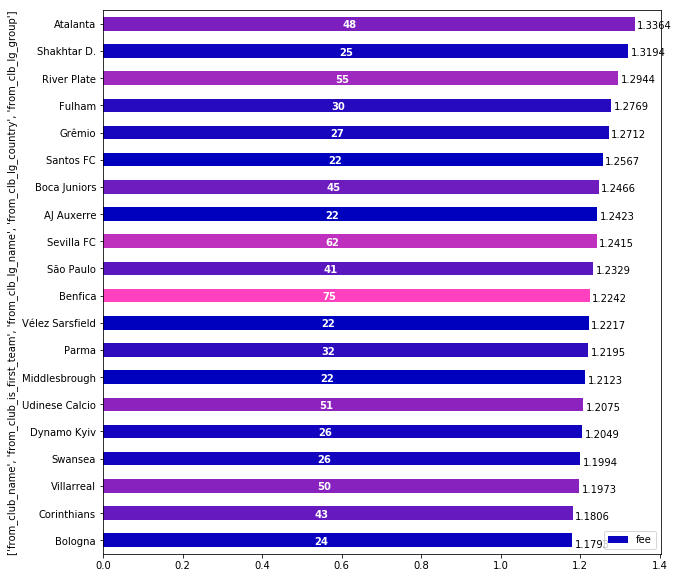

In [243]:
plot_fee_dep(df=from_clb.query('times > 20'), limit=20, asc=False, feature=f)

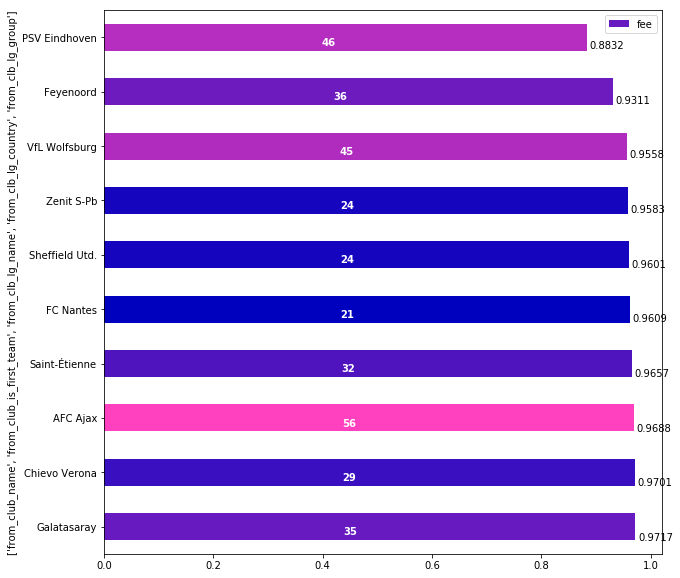

In [244]:
plot_fee_dep(df=from_clb.query('times > 20'), limit=10, asc=True, feature=f)

In [245]:
f = feats[21]
f

"['to_club_name', 'to_club_is_first_team', 'to_clb_lg_name', 'to_clb_lg_country', 'to_clb_lg_group']"

In [246]:
to_clb = get_pd_main_chained_feat(feat_table=get_pd(f, min_tm=10), main_feat_idx=0)
to_clb

,value,fee,times
6337,Man Utd,1.892115,70.0
6338,Chelsea,1.750309,110.0
6339,Bournemouth,1.707901,13.0
6340,Anzhi,1.693653,26.0
6341,Liverpool,1.683450,102.0
6343,Spurs,1.627977,105.0
6344,Everton,1.584751,72.0
6345,Arsenal,1.573494,72.0
6346,Middlesbrough,1.557440,38.0
6348,Watford,1.526497,27.0


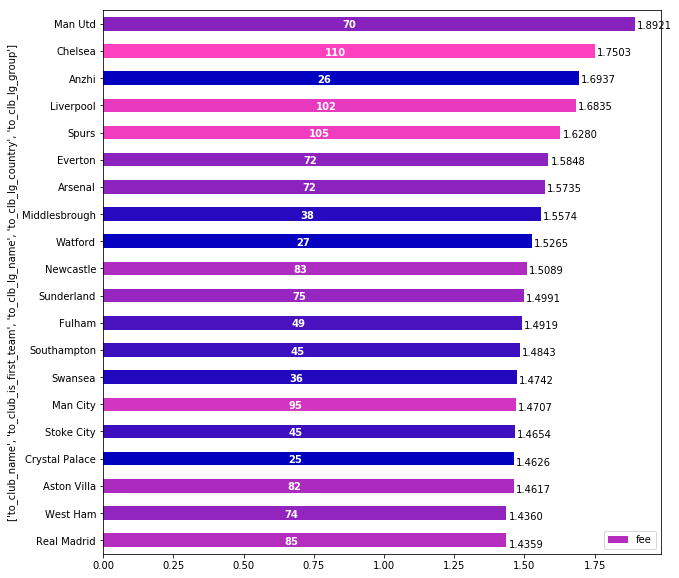

In [247]:
plot_fee_dep(df=to_clb.query('times > 20'), limit=20, asc=False, feature=f)

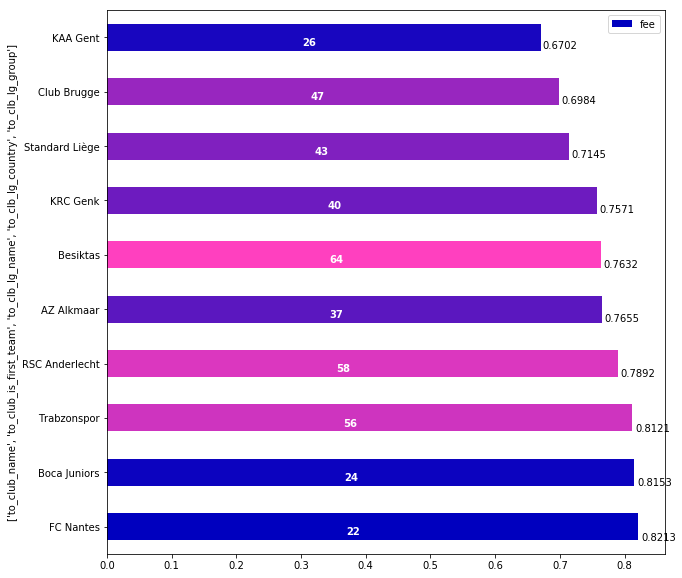

In [248]:
plot_fee_dep(df=to_clb.query('times > 20'), limit=10, asc=True, feature=f)

In [249]:
from_clb_ = from_clb.copy(); from_clb_['value'] = from_clb_['value'].astype(str)
to_clb_ = to_clb.copy(); to_clb_['value'] = to_clb_['value'].astype(str)

In [250]:
clb_eff = from_clb_.merge(right=to_clb_, on=['value'])
clb_eff['fee'] = clb_eff['fee_x']/clb_eff['fee_y']
clb_eff['times'] = clb_eff['times_x'] + clb_eff['times_y']
clb_eff = clb_eff[['value', 'fee', 'times']].sort_values('fee', ascending=False)

In [251]:
clb_eff.query('times > 50')

,value,fee,times
141,KAA Gent,1.575071,51.0
10,Boca Juniors,1.529133,69.0
6,River Plate,1.508334,77.0
159,Club Brugge,1.486756,74.0
89,AZ Alkmaar,1.445079,78.0
165,Standard Liège,1.437162,82.0
132,Besiktas,1.401246,89.0
151,KRC Genk,1.374644,68.0
161,RSC Anderlecht,1.309661,110.0
19,Benfica,1.298773,159.0


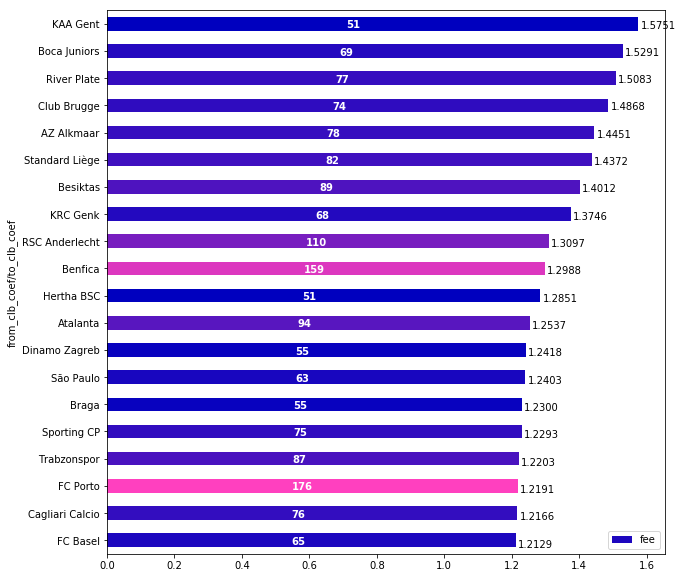

In [252]:
plot_fee_dep(df=clb_eff.query('times > 50'), limit=20, asc=False, feature="from_clb_coef/to_clb_coef")

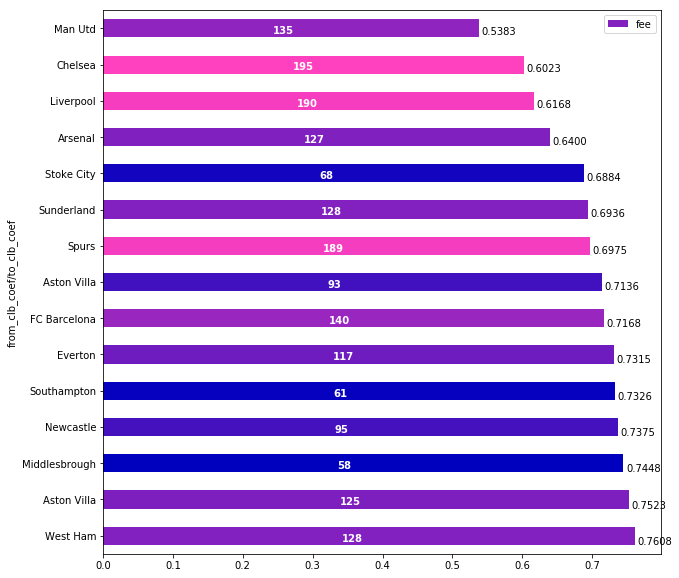

In [253]:
plot_fee_dep(df=clb_eff.query('times > 50'), limit=15, asc=True, feature="from_clb_coef/to_clb_coef")

In [254]:
rus_clubs = train_df.query("from_clb_lg_country == 'Russia'")['from_club_name'].unique()

In [256]:
clb_eff_rus = clb_eff[clb_eff['value'].isin(rus_clubs)]
clb_eff_rus

,value,fee,times
74,CSKA Moscow,0.937919,57.0
109,Spartak Moscow,0.915475,89.0
149,Loko Moscow,0.914955,80.0
155,Dinamo Moscow,0.898594,70.0
123,Rubin Kazan,0.873271,67.0
204,Zenit S-Pb,0.792416,84.0
18,Anzhi,0.725005,44.0


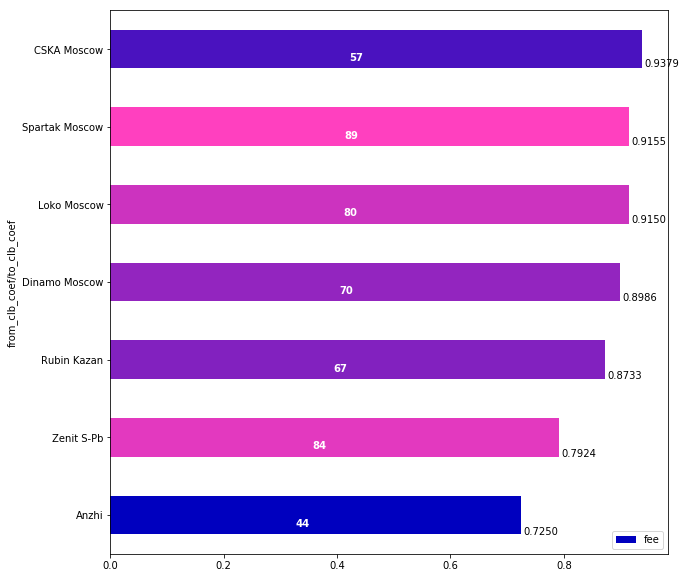

In [257]:
plot_fee_dep(df=clb_eff_rus, asc=False, feature="from_clb_coef/to_clb_coef")

##### Position

In [95]:
get_pd(feats[10], min_tm=20)

,feature,value,fee,times
561,"['plr_position_main', 'plr_position_0']","[Attacking Midfield, Left Winger]",1.066025,74.0
562,"['plr_position_main', 'plr_position_0']","[Attacking Midfield, Attacking Midfield]",1.055193,560.0
564,"['plr_position_main', 'plr_position_0']","[Left Winger, Left Winger]",1.048999,471.0
567,"['plr_position_main', 'plr_position_0']","[Attacking Midfield, Central Midfield]",1.043311,26.0
569,"['plr_position_main', 'plr_position_0']","[Attacking Midfield, Right Winger]",1.042498,31.0
576,"['plr_position_main', 'plr_position_0']","[Central Midfield, Attacking Midfield]",1.028689,64.0
579,"['plr_position_main', 'plr_position_0']","[Right Winger, Right Winger]",1.025786,488.0
581,"['plr_position_main', 'plr_position_0']","[Centre-Forward, Centre-Forward]",1.025395,2395.0
582,"['plr_position_main', 'plr_position_0']","[Right Winger, Centre-Forward]",1.025110,48.0
583,"['plr_position_main', 'plr_position_0']","[Left Winger, Right Winger]",1.025103,24.0


In [96]:
get_pd(feats[11], min_tm=20)

,feature,value,fee,times
661,plr_other_positions,"Second Striker, Left Winger",1.079030,120.0
662,plr_other_positions,"Centre-Forward, Attacking Midfield",1.075558,26.0
664,plr_other_positions,"Centre-Forward, Second Striker",1.056079,33.0
665,plr_other_positions,"Left Winger, Central Midfield",1.055251,33.0
667,plr_other_positions,"Central Midfield, Right-Back",1.053377,40.0
673,plr_other_positions,"Attacking Midfield, Defensive Midfield",1.038508,162.0
674,plr_other_positions,"Left Midfield, Right-Back",1.037605,32.0
675,plr_other_positions,"Left-Back, Left Midfield",1.037561,25.0
676,plr_other_positions,"Central Midfield, Centre-Back",1.036110,102.0
677,plr_other_positions,"Centre-Forward, Right Winger",1.034738,62.0


In [97]:
 get_pd(feats[25], min_tm=20)

,feature,value,fee,times
8746,plr_position_1,Attacking Midfield,1.025986,655.0
8747,plr_position_1,Second Striker,1.018257,723.0
8748,plr_position_1,Defensive Midfield,1.015852,858.0
8749,plr_position_1,Centre-Forward,1.013710,311.0
8750,plr_position_1,Left-Back,1.007444,541.0
8751,plr_position_1,Central Midfield,1.001890,952.0
8752,plr_position_1,Right Winger,1.000000,1166.0
8753,plr_position_1,NaN,0.996113,1183.0
8754,plr_position_1,Left Winger,0.992267,1283.0
8755,plr_position_1,Right-Back,0.990595,634.0


In [98]:
get_pd(feats[26], min_tm=20)

,feature,value,fee,times
8759,plr_position_2,Attacking Midfield,1.006466,957.0
8760,plr_position_2,Right Winger,1.006430,1023.0
8761,plr_position_2,Defensive Midfield,1.004552,556.0
8762,plr_position_2,NaN,1.003257,2289.0
8763,plr_position_2,Second Striker,1.002112,673.0
8764,plr_position_2,Left-Back,1.001407,392.0
8765,plr_position_2,Centre-Forward,1.000000,369.0
8766,plr_position_2,Left Winger,0.999270,1029.0
8767,plr_position_2,Central Midfield,0.997877,377.0
8768,plr_position_2,Left Midfield,0.997428,674.0


##### Сoach

In [31]:
f = feats[23]
f

'to_coach_name'

In [33]:
to_coach = get_pd(f, min_tm=10)
to_coach

,feature,value,fee,times
7097,to_coach_name,Marcello Lippi,1.568035,30.0
7098,to_coach_name,José Antonio Camacho,1.564914,11.0
7106,to_coach_name,Javier Irureta,1.447734,21.0
7116,to_coach_name,Paul Clement,1.417133,16.0
7117,to_coach_name,Fabio Capello,1.404437,36.0
7121,to_coach_name,Leonardo Jardim,1.393394,42.0
7122,to_coach_name,Jorge Sampaoli,1.389850,11.0
7129,to_coach_name,Alberto Malesani,1.369581,22.0
7130,to_coach_name,Gareth Southgate,1.369340,11.0
7131,to_coach_name,Mauricio Pochettino,1.364261,34.0


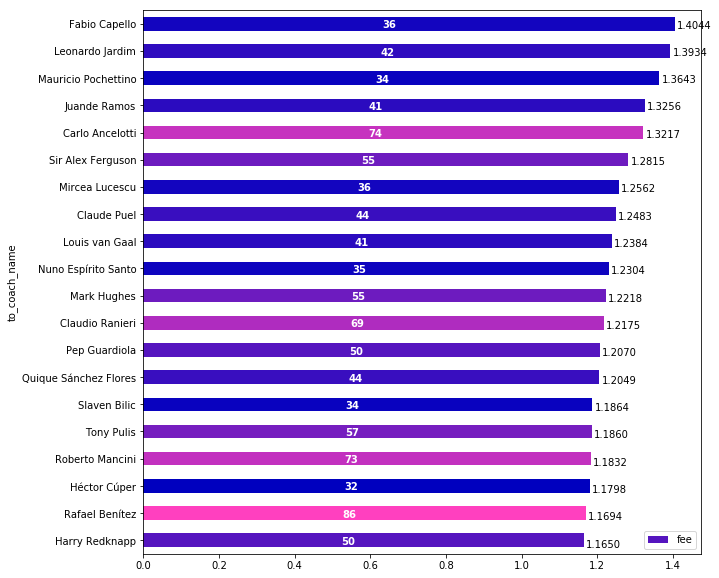

In [34]:
plot_fee_dep(df=to_coach.query('times > 30'), limit=20, asc=False, feature=f)

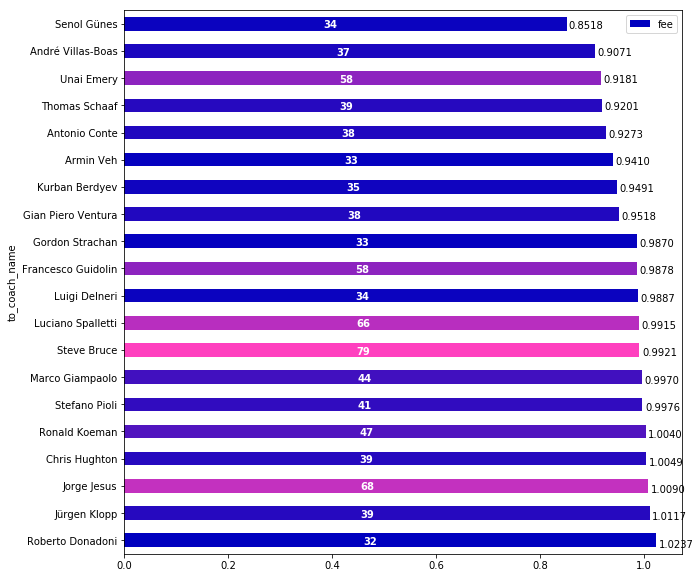

In [36]:
plot_fee_dep(df=to_coach.query('times > 30').query("value.notnull()", engine='python'), limit=20, asc=True, feature=f)

In [37]:
f = feats[19]
f

'from_coach_name'

In [38]:
from_coach = get_pd(f, min_tm=10)
from_coach

,feature,value,fee,times
3790,from_coach_name,Gregorio Manzano,1.449138,21.0
3793,from_coach_name,Davide Ballardini,1.446346,18.0
3806,from_coach_name,Diego Simeone,1.421720,52.0
3810,from_coach_name,Vanderlei Luxemburgo,1.413028,12.0
3829,from_coach_name,Sir Bobby Robson,1.369791,12.0
3836,from_coach_name,Leonardo Jardim,1.366803,43.0
3837,from_coach_name,Fatih Terim,1.366073,14.0
3860,from_coach_name,László Bölöni,1.317289,12.0
3871,from_coach_name,Rémi Garde,1.304090,11.0
3883,from_coach_name,Manuel Pellegrini,1.292864,39.0


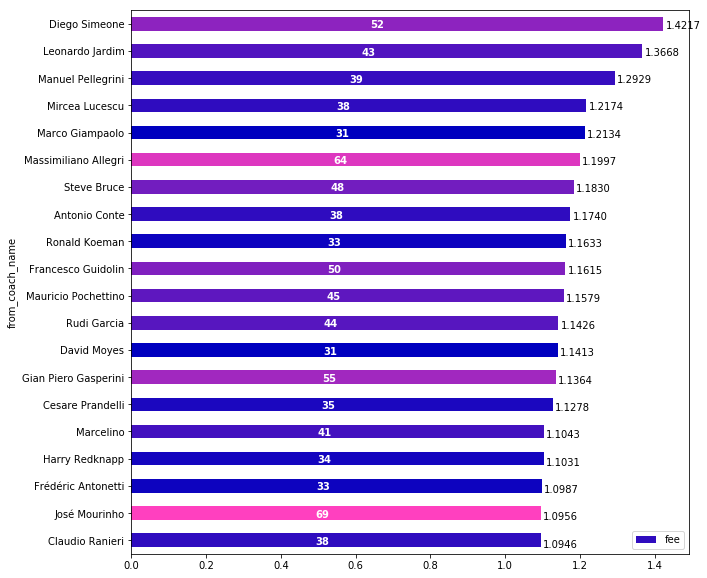

In [39]:
plot_fee_dep(df=from_coach.query('times > 30'), limit=20, asc=False, feature=f)

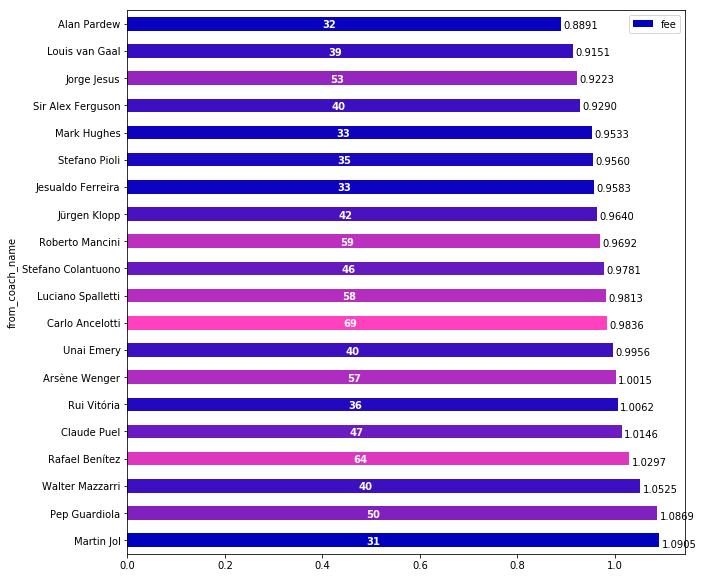

In [41]:
plot_fee_dep(df=from_coach.query('times > 30').query("value.notnull()", engine='python'), limit=20, asc=True, feature=f)

In [133]:
pd_['to-coach-club'] = get_part_dep(df=df, learn=learn, bs=BS, coef=10, 
             dep_name=dep_var, is_sorted=True, fields=[['to_coach_name', 'to_club_name']])
pd_['to-coach-club']

,feature,value,fee,times
0,"['to_coach_name', 'to_club_name']","[Guus Hiddink, Anzhi]",1.529576,10
1,"['to_coach_name', 'to_club_name']","[Sir Alex Ferguson, Man Utd]",1.508432,55
2,"['to_coach_name', 'to_club_name']","[Louis van Gaal, Man Utd]",1.486168,12
3,"['to_coach_name', 'to_club_name']","[Marcello Lippi, Juventus]",1.477353,18
4,"['to_coach_name', 'to_club_name']","[Gadzhi Gadzhiev, Anzhi]",1.442440,14
5,"['to_coach_name', 'to_club_name']","[Leonardo Jardim, Monaco]",1.404217,40
6,"['to_coach_name', 'to_club_name']","[Mauricio Pochettino, Spurs]",1.401487,22
7,"['to_coach_name', 'to_club_name']","[José Mourinho, Man Utd]",1.380284,10
8,"['to_coach_name', 'to_club_name']","[Ralph Hasenhüttl, RB Leipzig]",1.373648,11
9,"['to_coach_name', 'to_club_name']","[Carlo Ancelotti, Real Madrid]",1.373053,10


In [55]:
pd_['from-coach-club'] = get_part_dep(df=df, learn=learn, bs=BS, coef=4, 
             dep_name=dep_var, is_sorted=True, fields=[['from_coach_name', 'from_club_name']])
pd_['from-coach-club'].query('times > 12')

,feature,value,fee,times
13,"['from_coach_name', 'from_club_name']","[Mircea Lucescu, Shakhtar D.]",1.339755,23
32,"['from_coach_name', 'from_club_name']","[Gregorio Manzano, RCD Mallorca]",1.264505,13
33,"['from_coach_name', 'from_club_name']","[Gian Piero Gasperini, Atalanta]",1.263126,16
44,"['from_coach_name', 'from_club_name']","[Diego Simeone, Atlético Madrid]",1.235887,43
63,"['from_coach_name', 'from_club_name']","[Leonardo Jardim, Monaco]",1.212095,35
86,"['from_coach_name', 'from_club_name']","[Tite, Corinthians]",1.174539,15
89,"['from_coach_name', 'from_club_name']","[Francesco Guidolin, Udinese Calcio]",1.170722,25
90,"['from_coach_name', 'from_club_name']","[Thomas Schaaf, Werder Bremen]",1.169413,23
99,"['from_coach_name', 'from_club_name']","[Staale Solbakken, FC Copenhagen]",1.161166,15
122,"['from_coach_name', 'from_club_name']","[Julen Lopetegui, FC Porto]",1.135427,14


In [70]:
sv_var(pd_, 'pd', path)

In [42]:
pd_ = ld_var('pd', path)

##### Stats

In [107]:
get_pd(feats[43], min_tm=10)

,feature,value,fee,times
9577,stats_minutes_0,12007.8,1.262678,11.0
9578,stats_minutes_0,11659.8,1.254342,11.0
9579,stats_minutes_0,11311.8,1.239384,14.0
9580,stats_minutes_0,10963.8,1.227654,12.0
9582,stats_minutes_0,10267.7,1.202166,18.0
9583,stats_minutes_0,9919.68,1.187613,35.0
9584,stats_minutes_0,9571.65,1.171376,43.0
9585,stats_minutes_0,9223.63,1.154710,53.0
9586,stats_minutes_0,8875.61,1.139436,84.0
9587,stats_minutes_0,8527.58,1.122307,103.0


##### Agent

In [57]:
f = feats[16]
f

'plr_player_agent'

In [58]:
agent = get_pd(f, min_tm=20).copy()
agent.query('times > 40')

,feature,value,fee,times
1458,plr_player_agent,Branchini Associati S.p.A.,1.289006,42.0
1508,plr_player_agent,Alessandro Lucci - WSA,1.239379,45.0
1517,plr_player_agent,Gestifute,1.233651,148.0
1577,plr_player_agent,not clarified,1.183182,206.0
1604,plr_player_agent,WMG Management (SFX Sports),1.169325,65.0
1623,plr_player_agent,LIAN SPORTS,1.152363,79.0
1628,plr_player_agent,Gr Sports,1.148996,41.0
1643,plr_player_agent,PDP s.r.l. Pasqualin D’Amico Partners,1.139307,65.0
1723,plr_player_agent,TMP SOCCER srl,1.092094,56.0
1730,plr_player_agent,Wasserman Netherlands,1.089101,51.0


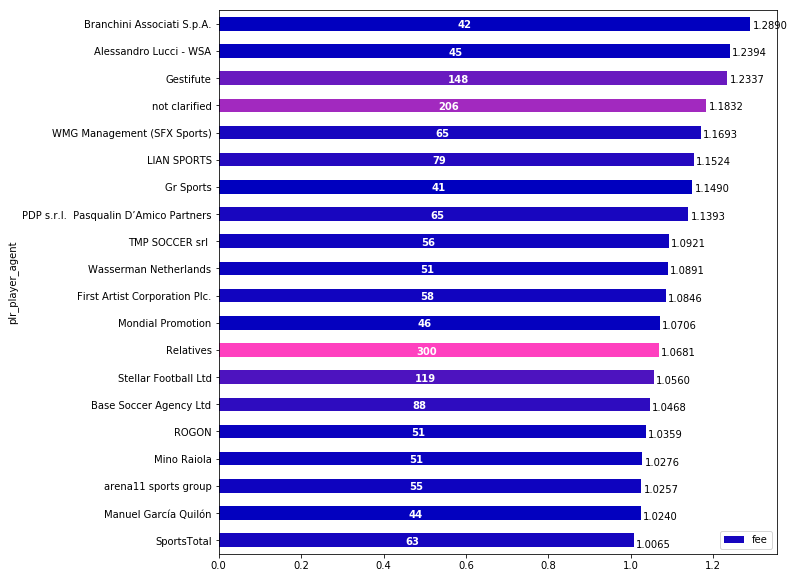

In [280]:
plot_fee_dep(df=agent.query('times > 40'), limit=20, asc=False, feature=f)

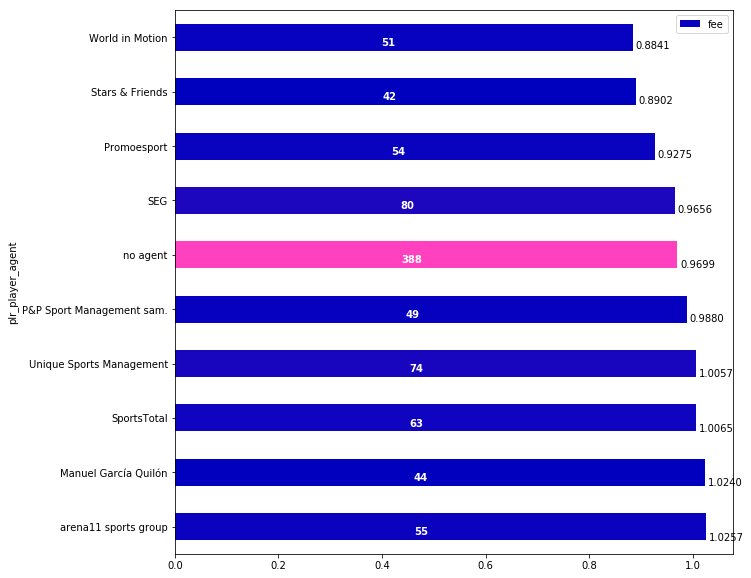

In [59]:
plot_fee_dep(df=agent.query('times > 40').query("value.notnull()", engine='python'), limit=10, asc=True, feature=f)

In [282]:
def agent_deal(agent):
    tmp_df = (train_df.query(f"plr_player_agent == '{agent}'")[['player_name', 'season', 'age', 'nat_national_name', 
                                                                'from_club_name', 'to_club_name', 'is_loan', 'pop_log1p', 
                                                                'fee']]).sort_values('season', ascending=False)
    tmp_df['pop_log1p'] = np.log10(np.exp(tmp_df['pop_log1p']))
    return tmp_df

In [283]:
agent_deal('World in Motion')

,player_name,season,age,nat_national_name,from_club_name,to_club_name,is_loan,pop_log1p,fee
7623,Lei Wu,2018,27.0,China,SIPG,Espanyol,False,4.725569,2000.0
7102,Sam Baldock,2018,29.0,England U20,Brighton,Reading,False,3.922362,3900.0
6164,Rachid Ghezzal,2018,26.0,Algeria,Monaco,Leicester,False,3.697229,14000.0
6625,Alex Smithies,2018,28.0,England U21,QPR,Cardiff,False,3.521792,4000.0
6136,Aden Flint,2018,28.0,NaN,Bristol City,Middlesbrough,False,4.630997,8000.0
9492,Danny Ward,2017,26.0,NaN,Rotherham,Cardiff,False,5.060698,1800.0
5545,Scott Malone,2017,26.0,England U20,Fulham,Huddersfield,False,4.604928,3900.0
4205,Ryan Mason,2016,25.0,England,Spurs,Hull City,False,4.325331,15400.0
2977,Conor Coady,2015,22.0,England U20,Huddersfield,Wolves,False,3.275772,2800.0
6626,Alex Smithies,2015,25.0,England U21,Huddersfield,QPR,False,3.129045,2100.0


In [121]:
agent_deal('Alessandro Lucci - WSA')

,player_name,season,age,nat_national_name,from_club_name,to_club_name,is_loan,pop_log1p,fee
167,Joaquín Correa,2018,23.0,Argentina,Sevilla FC,Lazio,False,4.423688,15000.0
206,Mattia Perin,2018,25.0,Italy,Genoa,Juventus,False,5.489145,12000.0
3265,Nenad Tomović,2018,30.0,Serbia,Fiorentina,Chievo Verona,False,3.648165,2500.0
1929,Leonardo Bonucci,2018,31.0,Italy,AC Milan,Juventus,False,5.517044,35000.0
1513,Matías Vecino,2017,25.0,Uruguay,Fiorentina,Inter,False,4.504811,24000.0
5914,Nicola Murru,2017,22.0,Italy U21,Cagliari Calcio,Sampdoria,False,3.844415,9000.0
1930,Leonardo Bonucci,2017,30.0,Italy,Juventus,AC Milan,False,4.801534,42000.0
1681,Davide Zappacosta,2017,25.0,Italy,Torino,Chelsea,False,3.504607,25000.0
497,Juan Cuadrado,2017,29.0,Colombia,Chelsea,Juventus,False,5.662870,20000.0
241,Luis Muriel,2017,26.0,Colombia,Sampdoria,Sevilla FC,False,4.478480,21500.0


In [123]:
agent_deal('Branchini Associati S.p.A.')

,player_name,season,age,nat_national_name,from_club_name,to_club_name,is_loan,pop_log1p,fee
2914,Jonathan Biabiany,2018,30.0,France U21,Inter,Parma,False,3.421604,1500.0
7207,Alfred Gomis,2018,24.0,Senegal,Torino,SPAL,False,4.801699,1500.0
1142,Leonardo Pavoletti,2018,29.0,Italy,SSC Napoli,Cagliari Calcio,False,3.759214,10000.0
355,Mattia De Sciglio,2017,24.0,Italy,AC Milan,Juventus,False,3.782688,12000.0
1143,Leonardo Pavoletti,2016,28.0,Italy,Genoa,SSC Napoli,False,4.105272,18000.0
1472,Blerim Dzemaili,2016,30.0,Switzerland,Galatasaray,Bologna,False,5.262285,1300.0
1144,Leonardo Pavoletti,2015,26.0,Italy,Sassuolo,Genoa,False,3.366236,3000.0
2078,Angelo Ogbonna,2015,27.0,Italy,Juventus,West Ham,False,4.334353,11000.0
1473,Blerim Dzemaili,2014,28.0,Switzerland,SSC Napoli,Galatasaray,False,4.859144,2350.0
5710,Andrea Poli,2013,23.0,Italy,Sampdoria,AC Milan,False,4.928908,9700.0


##### league

In [316]:
league = get_part_dep(df=df, learn=learn, bs=BS, coef=1, 
             dep_name=dep_var, is_sorted=True, fields=[['from_clb_lg_name', 'from_clb_lg_country', 'from_clb_lg_group']])

In [317]:
from_league = get_pd_main_chained_feat(feat_table=league, main_feat_idx=1).query("value.notnull()", engine='python')
from_league

,value,fee,times
0,Spain,1.055591,726
1,Italy,1.050557,1205
2,England,1.047729,1127
3,Germany,1.032346,579
4,France,1.016602,778
5,Russia,1.000000,248
6,Turkey,0.996676,230
7,Belgium,0.996402,271
9,Netherlands,0.985159,359
10,Portugal,0.975351,347


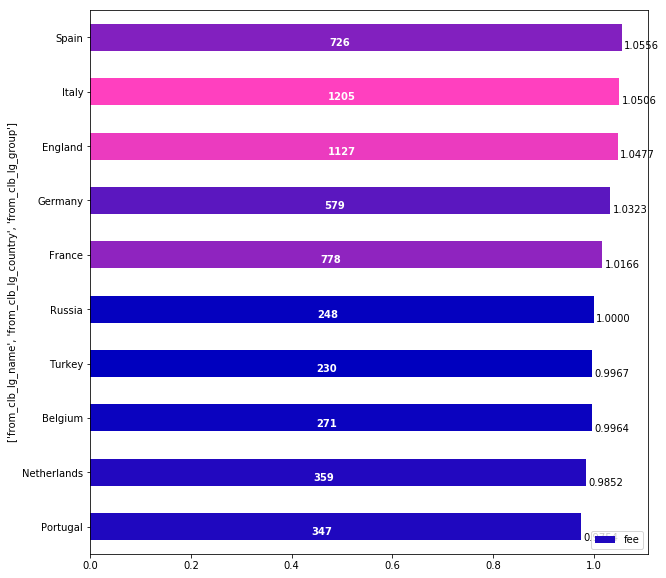

In [306]:
plot_fee_dep(df=from_league, asc=False, feature=str(['from_clb_lg_name', 'from_clb_lg_country', 'from_clb_lg_group']))

In [308]:
league = get_part_dep(df=df, learn=learn, bs=BS, coef=1, 
             dep_name=dep_var, is_sorted=True, fields=['from_clb_lg_group'])
league

,feature,value,fee,times
0,from_clb_lg_group,1.0,1.022191,1853.0
1,from_clb_lg_group,2.0,1.015877,2562.0
2,from_clb_lg_group,NaN,1.000000,3891.0
3,from_clb_lg_group,4.0,0.999940,501.0
4,from_clb_lg_group,3.0,0.993831,954.0


In [309]:
league = get_part_dep(df=df, learn=learn, bs=BS, coef=1, 
             dep_name=dep_var, is_sorted=True, fields=[['to_clb_lg_name', 'to_clb_lg_country', 'to_clb_lg_group']])

In [310]:
to_league = get_pd_main_chained_feat(feat_table=league, main_feat_idx=1).query("value.notnull()", engine='python')
to_league

,value,fee,times
0,England,1.258053,1601
1,Spain,1.097905,841
2,Italy,1.044976,1446
3,Russia,1.041172,417
4,Germany,1.026717,862
5,France,1.000000,799
7,Portugal,0.916992,262
8,Netherlands,0.895379,255
9,Turkey,0.838319,350
10,Belgium,0.784489,224


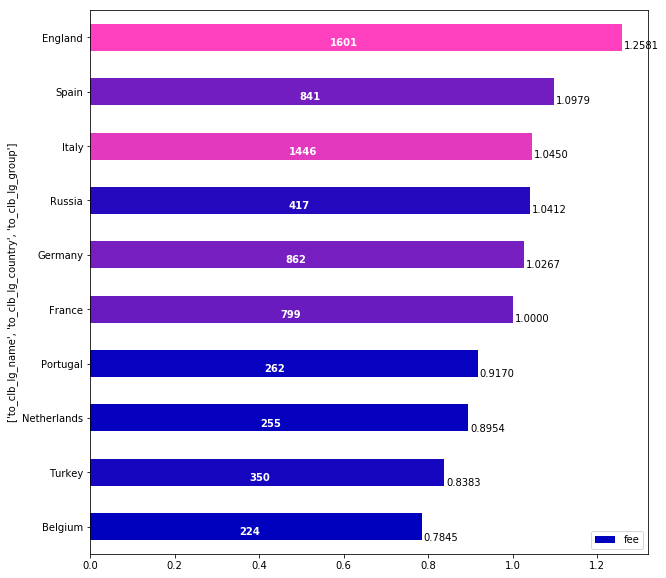

In [311]:
plot_fee_dep(df=to_league, asc=False, feature=str(['to_clb_lg_name', 'to_clb_lg_country', 'to_clb_lg_group']))

##### nationality

In [61]:
get_pd(feats[12], min_tm=20)

,feature,value,fee,times
785,"['plr_nationality_name', 'plr_place_of_birth_c...","[Brazil, Brazil]",1.100154,880.0
787,"['plr_nationality_name', 'plr_place_of_birth_c...","[Argentina, Argentina]",1.091092,598.0
793,"['plr_nationality_name', 'plr_place_of_birth_c...","[Ukraine, UdSSR]",1.080262,22.0
795,"['plr_nationality_name', 'plr_place_of_birth_c...","[Scotland, Scotland]",1.078330,79.0
796,"['plr_nationality_name', 'plr_place_of_birth_c...","[Italy, Brazil]",1.077229,23.0
802,"['plr_nationality_name', 'plr_place_of_birth_c...","[Serbia, Yugoslavia (Republic)]",1.073399,40.0
803,"['plr_nationality_name', 'plr_place_of_birth_c...","[Colombia, Colombia]",1.073283,137.0
813,"['plr_nationality_name', 'plr_place_of_birth_c...","[Wales, Wales]",1.066961,47.0
822,"['plr_nationality_name', 'plr_place_of_birth_c...","[Italy, Italy]",1.058652,755.0
826,"['plr_nationality_name', 'plr_place_of_birth_c...","[Senegal, Senegal]",1.055757,92.0


In [63]:
get_pd('nat_matches_played', min_tm=20)

,feature,value,fee,times
8979,nat_matches_played,111.032,1.036303,44.0
8981,nat_matches_played,106.399,1.034559,29.0
8982,nat_matches_played,104.082,1.034402,39.0
8983,nat_matches_played,101.766,1.033917,24.0
8984,nat_matches_played,115.665,1.033096,24.0
8986,nat_matches_played,99.4494,1.031723,26.0
8987,nat_matches_played,97.1329,1.030799,58.0
8988,nat_matches_played,94.8165,1.030342,31.0
8990,nat_matches_played,92.5,1.029529,39.0
8992,nat_matches_played,90.1835,1.027459,31.0


In [65]:
len(df)

9761

##### loan

In [66]:
get_pd(feats[7], min_tm=20)

,feature,value,fee,times
337,is_loan,False,1.269851,9444.0
338,is_loan,True,0.730149,317.0
